In [ ]:
# Setup for Colab/Kaggle
import os
import sys

# --- CONFIGURATION ---
# REPLACE 'USERNAME/REPO_NAME' with your actual GitHub repository path before running remotely!
REPO_URL = "https://github.com/tomal66/AD-SFL.git"
REPO_NAME = "AD-SFL"
# ---------------------

if not os.path.exists("simulation.py"):
    if not os.path.exists(REPO_NAME):
        print(f"Cloning {REPO_URL}...")
        get_ipython().system(f"git clone {REPO_URL}")
        get_ipython().run_line_magic("cd", REPO_NAME)
        print("Installing requirements...")
        get_ipython().system("pip install -r requirements.txt")
    else:
        get_ipython().run_line_magic("cd", REPO_NAME)
        
# Add current directory to path just in case
sys.path.append(os.getcwd())

# Multi-Seed SafeSplit Experimentation

This notebook runs the SafeSplit simulation across multiple random seeds to gather statistically significant results.
It calculates the Mean and 95% Confidence Intervals (CI) for both Accuracy and Attack Success Rate (ASR) and visualizes them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import sys
import os

# Ensure simulation.py is accessible
if not os.path.exists("simulation.py"):
    raise FileNotFoundError("simulation.py not found. Please run this notebook in the project root.")

from simulation import run_simulation

print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Torch version: 2.8.0+cu126
CUDA available: True


In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed} ✅")

## Configuration

Define your hyperparameters and the list of seeds to test.

In [3]:
seeds = [42, 101, 2024, 7, 99]  # 5 seeds for statistics

config = {
    # Experiment Parameters
    "num_clients": 10,
    "rounds": 50,
    "poison_ratio": 0.2,
    "target_label": 0,
    "dataset": "mnist",
    "distribution": "non_iid", # 'iid' or 'non_iid'
    "alpha": 0.5,

    # Training Hyperparameters
    "lr": 0.01,
    "momentum": 0.9,
    "batch_size": 32,
    "test_batch_size": 256,

    # Defense Controls
    "defense_enabled": True,
    "low_freq_ratio": 0.25,
}

## Run Simulation Loop

In [4]:
# Store results: list of lists (num_seeds x num_rounds)
all_acc = []
all_asr = []
all_loss = []

print(f"Starting multi-seed experiment on {len(seeds)} seeds...")

for s in seeds:
    print(f"\n--- Running Seed {s} ---")
    seed_everything(s)
    
    # Run simulation
    # NOTE: run_simulation returns dict {"loss": [], "acc": [], "asr": []}
    history = run_simulation(config)
    
    all_acc.append(history["acc"])
    all_asr.append(history["asr"])
    all_loss.append(history["loss"])

print("\nAll runs generated.")

Starting multi-seed experiment on 5 seeds...

--- Running Seed 42 ---
Seed set to 42 ✅
Starting Training for 50 rounds on mnist...
Round 1/50 - Loss: 0.4045 - Val Acc: 95.78% - ASR: 10.05%
Round 2/50 - Loss: 0.0836 - Val Acc: 98.29% - ASR: 9.73%
Round 3/50 - Loss: 0.0663 - Val Acc: 98.04% - ASR: 9.69%
Round 4/50 - Loss: 0.0679 - Val Acc: 98.08% - ASR: 9.71%
Round 5/50 - Loss: 0.0714 - Val Acc: 98.01% - ASR: 9.66%
Round 6/50 - Loss: 0.0630 - Val Acc: 98.47% - ASR: 9.93%
Round 7/50 - Loss: 0.0663 - Val Acc: 98.57% - ASR: 9.93%
Round 8/50 - Loss: 0.0603 - Val Acc: 98.66% - ASR: 9.98%
Round 9/50 - Loss: 0.0620 - Val Acc: 98.60% - ASR: 9.96%
Round 10/50 - Loss: 0.0669 - Val Acc: 98.44% - ASR: 10.10%
Round 11/50 - Loss: 0.0584 - Val Acc: 98.55% - ASR: 9.87%
Round 12/50 - Loss: 0.0596 - Val Acc: 98.23% - ASR: 10.01%
Round 13/50 - Loss: 0.0580 - Val Acc: 98.62% - ASR: 10.05%
Round 14/50 - Loss: 0.0640 - Val Acc: 98.62% - ASR: 9.75%
Round 15/50 - Loss: 0.0736 - Val Acc: 98.68% - ASR: 9.92%
Roun

## Statistical Analysis

Computing Mean and 95% Confidence Intervals.

In [5]:
# Convert to numpy arrays for easier calculation
# Shape: (num_seeds, num_rounds)
arr_acc = np.array(all_acc)
arr_asr = np.array(all_asr)

# Calculate Mean and Std Error
mean_acc = np.mean(arr_acc, axis=0)
mean_asr = np.mean(arr_asr, axis=0)

std_err_acc = np.std(arr_acc, axis=0, ddof=1) / np.sqrt(len(seeds))
std_err_asr = np.std(arr_asr, axis=0, ddof=1) / np.sqrt(len(seeds))

# T-value approximation for 95% CI
# DoF = N - 1
t_values = {
    1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571, 
    6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262, 10: 2.228
}
N = len(seeds)
t_val = t_values.get(N-1, 1.96) # Default to 1.96 (Z-score) for large N
print(f"Using T-value: {t_val} for N={N}")

ci_acc = t_val * std_err_acc
ci_asr = t_val * std_err_asr

print("Final Round Results (Mean ± 95% CI):")
print(f"Accuracy: {mean_acc[-1]:.2f}% ± {ci_acc[-1]:.2f}%")
print(f"ASR:      {mean_asr[-1]:.2f}% ± {ci_asr[-1]:.2f}%")

Using T-value: 2.776 for N=5
Final Round Results (Mean ± 95% CI):
Accuracy: 98.83% ± 0.16%
ASR:      9.92% ± 0.10%


## Visualization

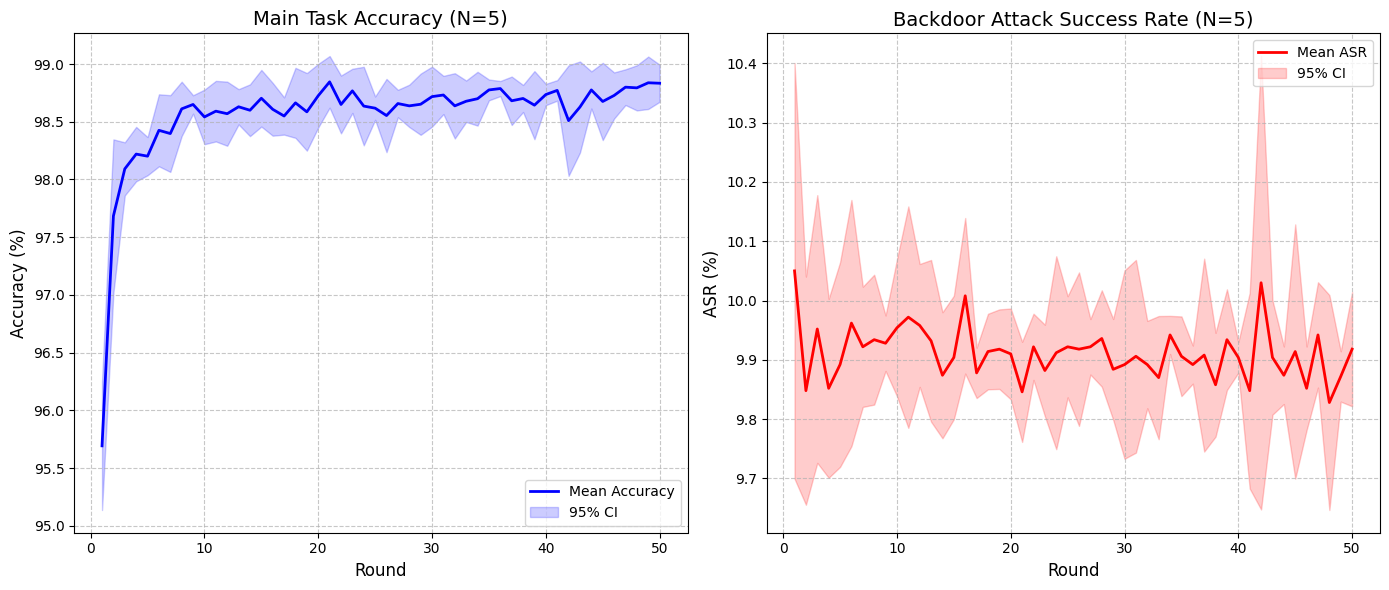

In [6]:
rounds = range(1, config['rounds'] + 1)

plt.figure(figsize=(14, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(rounds, mean_acc, label='Mean Accuracy', color='blue', linewidth=2)
plt.fill_between(rounds, mean_acc - ci_acc, mean_acc + ci_acc, color='blue', alpha=0.2, label='95% CI')
plt.title(f"Main Task Accuracy (N={len(seeds)})", fontsize=14)
plt.xlabel("Round", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

# Plot ASR
plt.subplot(1, 2, 2)
plt.plot(rounds, mean_asr, label='Mean ASR', color='red', linewidth=2)
plt.fill_between(rounds, mean_asr - ci_asr, mean_asr + ci_asr, color='red', alpha=0.2, label='95% CI')
plt.title(f"Backdoor Attack Success Rate (N={len(seeds)})", fontsize=14)
plt.xlabel("Round", fontsize=12)
plt.ylabel("ASR (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()